![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/1.SparkNLP_Basics.ipynb)

# Spark NLP Basics and Pretrained Pipelines

## 0. Colab Setup

In [1]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4
! pip install --ignore-installed -q spark-nlp==2.5.4

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
     |████████████████████████████████| 215.7MB 55kB/s 
     |████████████████████████████████| 204kB 44.1MB/s 
     |████████████████████████████████| 133kB 3.5MB/s 



#### **How to prevent Google Colab from disconnecting?**

Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if user does not interact with his Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is **12 hours.**

Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I then click on console tab and type this on the console prompt. (for mac press Option+Command+I)



In [ ]:
''' 

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

'''

## 1. Start Spark Session

In [2]:
import sparknlp

spark = sparknlp.start()

# params =>> gpu=False, spark23=False (start with spark 2.3)

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)


Spark NLP version 2.5.4
Apache Spark version: 2.4.4



<b>  if you want to work with Spark 2.3 </b>
```
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-2.3.0/spark-2.3.0-bin-hadoop2.7.tgz

!tar xf spark-2.3.0-bin-hadoop2.7.tgz
!pip install -q findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_HOME"] = "/content/spark-2.3.0-bin-hadoop2.7"
! java -version

import findspark
findspark.init()
from pyspark.sql import SparkSession

! pip install --ignore-installed -q spark-nlp==2.5.5
import sparknlp

spark = sparknlp.start(spark23=True)
```

`sparknlp.start()` will start or get SparkSession with predefined parameters hardcoded in `spark-nlp/python/sparknlp/__init__.py`. here is what is going on under the hood when you run `sparknlp.start()` 

In [ ]:
# https://github.com/JohnSnowLabs/spark-nlp/blob/master/python/sparknlp/__init__.py

from pyspark.sql import SparkSession

def start(gpu=False, spark23=False):
    current_version="2.5.4"
    maven_spark24 = "com.johnsnowlabs.nlp:spark-nlp_2.11:{}".format(current_version)
    maven_gpu_spark24 = "com.johnsnowlabs.nlp:spark-nlp-gpu_2.11:{}".format(current_version)
    maven_spark23 = "com.johnsnowlabs.nlp:spark-nlp-spark23_2.11:{}".format(current_version)
    maven_gpu_spark23 = "com.johnsnowlabs.nlp:spark-nlp-gpu-spark23_2.11:{}".format(current_version)

    builder = SparkSession.builder \
        .appName("Spark NLP") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "1000M") \
        .config("spark.driver.maxResultSize", "0")
    if gpu and spark23:
        builder.config("spark.jars.packages", maven_gpu_spark23)
    elif spark23:
        builder.config("spark.jars.packages", maven_spark23)
    elif gpu:
        builder.config("spark.jars.packages", maven_gpu_spark24)
    else:
        builder.config("spark.jars.packages", maven_spark24)
        
    return builder.getOrCreate()


If you want to start `SparkSession` with your own parameters or you need to load the required jars/packages from your local disk, or you have no internet connection (that would be needed to pull the required packages from internet), you can skip `sparknlp.start()` and start your session manually as shown below.


In [ ]:
"""
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spark NLP Enterprise 2.4.5") \
    .master("local[8]") \
    .config("spark.driver.memory","12G") \
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "800M")\
    .config("spark.jars", "{}spark-nlp-2.4.5.jar,{}spark-nlp-jsl-2.4.5.jar".format(jar_path,jar_path)) \
    .getOrCreate()
    
"""

CPU on Apache Spark 2.4.x: https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/spark-nlp-assembly-2.5.4.jar

GPU on Apache Spark 2.4.x: https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/spark-nlp-gpu-assembly-2.5.4.jar

CPU on Apache Spark 2.3.x: https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/spark-nlp-spark23-assembly-2.5.4.jar

GPU on Apache Spark 2.3.x: https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/spark-nlp-spark23-gpu-assembly-2.5.4.jar

## 2. Using Pretrained Pipelines

https://github.com/JohnSnowLabs/spark-nlp-models

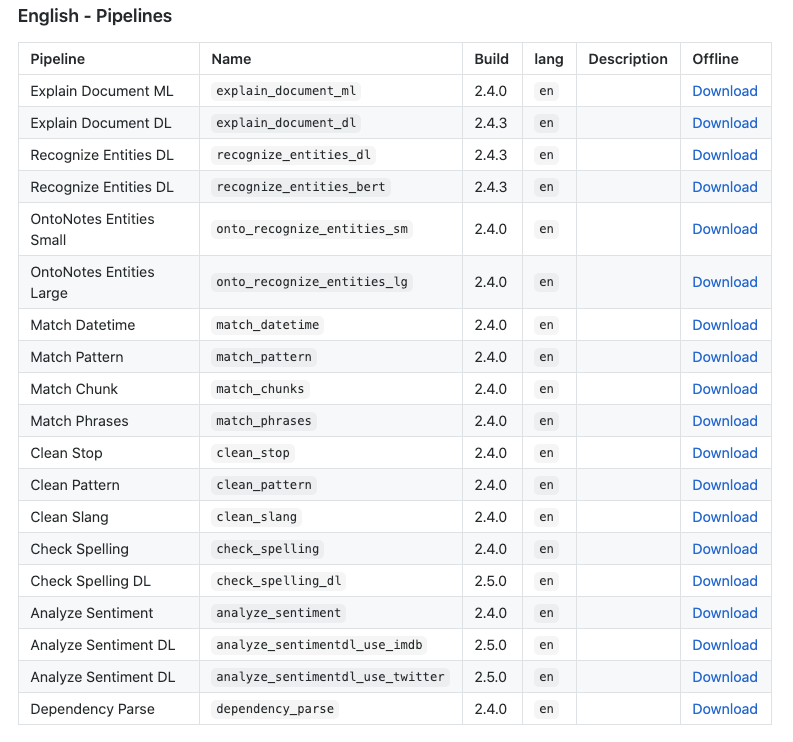

In [4]:
from sparknlp.pretrained import PretrainedPipeline

In [ ]:
testDoc = '''
Peter is a very good persn.
My life in Russia is very intersting.
John and Peter are brothrs. However they don't support each other that much.
Lucas Nogal Dunbercker is no longer happy. He has a good car though.
Europe is very culture rich. There are huge churches! and big houses!
'''

### Explain Document ML

**Stages**
- DocumentAssembler
- SentenceDetector
- Tokenizer
- Lemmatizer
- Stemmer
- Part of Speech
- SpellChecker (Norvig)




In [ ]:
pipeline = PretrainedPipeline('explain_document_ml', lang='en')


explain_document_ml download started this may take some time.
Approx size to download 9.4 MB
[OK!]


In [ ]:
# Load pretrained pipeline from local disk:

pipeline_local = PretrainedPipeline.from_disk('/root/cache_pretrained/explain_document_ml_en_2.4.0_2.4_1580252705962')

In [ ]:
%%time

result = pipeline.annotate(testDoc)

CPU times: user 40.9 ms, sys: 14.8 ms, total: 55.7 ms
Wall time: 1.25 s


In [ ]:
result.keys()

dict_keys(['document', 'spell', 'pos', 'lemmas', 'token', 'stems', 'sentence'])

In [ ]:
result['sentence']

['Peter is a very good persn.',
 'My life in Russia is very intersting.',
 'John and Peter are brothrs.',
 "However they don't support each other that much.",
 'Lucas Nogal Dunbercker is no longer happy.',
 'He has a good car though.',
 'Europe is very culture rich.',
 'There are huge churches!',
 'and big houses!']

In [ ]:
result['token']

['Peter',
 'is',
 'a',
 'very',
 'good',
 'persn',
 '.',
 'My',
 'life',
 'in',
 'Russia',
 'is',
 'very',
 'intersting',
 '.',
 'John',
 'and',
 'Peter',
 'are',
 'brothrs',
 '.',
 'However',
 'they',
 "don't",
 'support',
 'each',
 'other',
 'that',
 'much',
 '.',
 'Lucas',
 'Nogal',
 'Dunbercker',
 'is',
 'no',
 'longer',
 'happy',
 '.',
 'He',
 'has',
 'a',
 'good',
 'car',
 'though',
 '.',
 'Europe',
 'is',
 'very',
 'culture',
 'rich',
 '.',
 'There',
 'are',
 'huge',
 'churches',
 '!',
 'and',
 'big',
 'houses',
 '!']

In [ ]:
list(zip(result['token'], result['pos']))

[('Peter', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('very', 'RB'),
 ('good', 'JJ'),
 ('persn', 'NN'),
 ('.', '.'),
 ('My', 'PRP$'),
 ('life', 'NN'),
 ('in', 'IN'),
 ('Russia', 'NNP'),
 ('is', 'VBZ'),
 ('very', 'RB'),
 ('intersting', 'JJ'),
 ('.', '.'),
 ('John', 'NNP'),
 ('and', 'CC'),
 ('Peter', 'NNP'),
 ('are', 'VBP'),
 ('brothrs', 'NNS'),
 ('.', '.'),
 ('However', 'RB'),
 ('they', 'PRP'),
 ("don't", 'VBP'),
 ('support', 'VB'),
 ('each', 'DT'),
 ('other', 'JJ'),
 ('that', 'IN'),
 ('much', 'JJ'),
 ('.', '.'),
 ('Lucas', 'NNP'),
 ('Nogal', 'NNP'),
 ('Dunbercker', 'NNP'),
 ('is', 'VBZ'),
 ('no', 'DT'),
 ('longer', 'RB'),
 ('happy', 'JJ'),
 ('.', '.'),
 ('He', 'PRP'),
 ('has', 'VBZ'),
 ('a', 'DT'),
 ('good', 'JJ'),
 ('car', 'NN'),
 ('though', 'IN'),
 ('.', '.'),
 ('Europe', 'NNP'),
 ('is', 'VBZ'),
 ('very', 'RB'),
 ('culture', 'RB'),
 ('rich', 'JJ'),
 ('.', '.'),
 ('There', 'EX'),
 ('are', 'VBP'),
 ('huge', 'JJ'),
 ('churches', 'NNS'),
 ('!', '.'),
 ('and', 'CC'),
 ('big', 'JJ'),
 ('house

In [ ]:
list(zip(result['token'], result['lemmas'], result['stems'], result['spell']))

[('Peter', 'Peter', 'peter', 'Peter'),
 ('is', 'be', 'i', 'is'),
 ('a', 'a', 'a', 'a'),
 ('very', 'very', 'veri', 'very'),
 ('good', 'good', 'good', 'good'),
 ('persn', 'person', 'person', 'person'),
 ('.', '.', '.', '.'),
 ('My', 'My', 'my', 'My'),
 ('life', 'life', 'life', 'life'),
 ('in', 'in', 'in', 'in'),
 ('Russia', 'Russia', 'russia', 'Russia'),
 ('is', 'be', 'i', 'is'),
 ('very', 'very', 'veri', 'very'),
 ('intersting', 'interest', 'interest', 'interesting'),
 ('.', '.', '.', '.'),
 ('John', 'John', 'john', 'John'),
 ('and', 'and', 'and', 'and'),
 ('Peter', 'Peter', 'peter', 'Peter'),
 ('are', 'be', 'ar', 'are'),
 ('brothrs', 'broth', 'broth', 'broths'),
 ('.', '.', '.', '.'),
 ('However', 'However', 'howev', 'However'),
 ('they', 'they', 'thei', 'they'),
 ("don't", "don't", "don't", "don't"),
 ('support', 'support', 'support', 'support'),
 ('each', 'each', 'each', 'each'),
 ('other', 'other', 'other', 'other'),
 ('that', 'that', 'that', 'that'),
 ('much', 'much', 'much', 'much

In [ ]:
import pandas as pd

df = pd.DataFrame({'token':result['token'], 
                      'corrected':result['spell'], 'POS':result['pos'],
                      'lemmas':result['lemmas'], 'stems':result['stems']})
df

,token,corrected,POS,lemmas,stems
0,Peter,Peter,NNP,Peter,peter
1,is,is,VBZ,be,i
2,a,a,DT,a,a
3,very,very,RB,very,veri
4,good,good,JJ,good,good
5,persn,person,NN,person,person
6,.,.,.,.,.
7,My,My,PRP$,My,my
8,life,life,NN,life,life
9,in,in,IN,in,in


### Explain Document DL

**Stages**
- DocumentAssembler
- SentenceDetector
- Tokenizer
- NER (NER with GloVe 100D embeddings, CoNLL2003 dataset)
- Lemmatizer
- Stemmer
- Part of Speech
- SpellChecker (Norvig)


In [ ]:
pipeline_dl = PretrainedPipeline('explain_document_dl', lang='en')


explain_document_dl download started this may take some time.
Approx size to download 168.4 MB
[OK!]


In [ ]:
%%time

result = pipeline_dl.annotate(testDoc)

result.keys()

CPU times: user 47.2 ms, sys: 20.4 ms, total: 67.6 ms
Wall time: 1.37 s


In [ ]:
result.keys()

dict_keys(['entities', 'stem', 'checked', 'lemma', 'document', 'pos', 'token', 'ner', 'embeddings', 'sentence'])

In [ ]:
result['entities']

['Peter', 'Russia', 'John', 'Peter', 'Lucas Nogal Dunbercker', 'Europe']

In [ ]:
df = pd.DataFrame({'token':result['token'], 'ner_label':result['ner'],
                      'spell_corrected':result['checked'], 'POS':result['pos'],
                      'lemmas':result['lemma'], 'stems':result['stem']})

df

,token,ner_label,spell_corrected,POS,lemmas,stems
0,Peter,B-PER,Peter,NNP,Peter,peter
1,is,O,is,VBZ,be,i
2,a,O,a,DT,a,a
3,very,O,very,RB,very,veri
4,good,O,good,JJ,good,good
5,persn,O,person,NN,person,person
6,.,O,.,.,.,.
7,My,O,My,PRP$,My,my
8,life,O,life,NN,life,life
9,in,O,in,IN,in,in


### Recognize Entities DL

In [5]:
recognize_entities = PretrainedPipeline('recognize_entities_dl', lang='en')


recognize_entities_dl download started this may take some time.
Approx size to download 159 MB
[OK!]


In [7]:
testDoc = '''
Peter is a very good persn.
My life in Russia is very intersting.
John and Peter are brothrs. However they don't support each other that much.
Lucas Nogal Dunbercker is no longer happy. He has a good car though.
Europe is very culture rich. There are huge churches! and big houses!
'''

result = recognize_entities.annotate(testDoc)

list(zip(result['token'], result['ner']))

[('Peter', 'B-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('very', 'O'),
 ('good', 'O'),
 ('persn', 'O'),
 ('.', 'O'),
 ('My', 'O'),
 ('life', 'O'),
 ('in', 'O'),
 ('Russia', 'B-LOC'),
 ('is', 'O'),
 ('very', 'O'),
 ('intersting', 'O'),
 ('.', 'O'),
 ('John', 'B-PER'),
 ('and', 'O'),
 ('Peter', 'B-PER'),
 ('are', 'O'),
 ('brothrs', 'O'),
 ('.', 'O'),
 ('However', 'O'),
 ('they', 'O'),
 ("don't", 'O'),
 ('support', 'O'),
 ('each', 'O'),
 ('other', 'O'),
 ('that', 'O'),
 ('much', 'O'),
 ('.', 'O'),
 ('Lucas', 'B-ORG'),
 ('Nogal', 'I-ORG'),
 ('Dunbercker', 'I-ORG'),
 ('is', 'O'),
 ('no', 'O'),
 ('longer', 'O'),
 ('happy', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('has', 'O'),
 ('a', 'O'),
 ('good', 'O'),
 ('car', 'O'),
 ('though', 'O'),
 ('.', 'O'),
 ('Europe', 'B-LOC'),
 ('is', 'O'),
 ('very', 'O'),
 ('culture', 'O'),
 ('rich', 'O'),
 ('.', 'O'),
 ('There', 'O'),
 ('are', 'O'),
 ('huge', 'O'),
 ('churches', 'O'),
 ('!', 'O'),
 ('and', 'O'),
 ('big', 'O'),
 ('houses', 'O'),
 ('!', 'O')]

### Clean Stop Words

In [8]:
clean_stop = PretrainedPipeline('clean_stop', lang='en')


clean_stop download started this may take some time.
Approx size to download 12.4 KB
[OK!]


In [12]:

result = clean_stop.annotate(testDoc)

' '.join(result['cleanTokens'])

"Peter good persn . life Russia intersting . John Peter brothrs . don't support . Lucas Nogal Dunbercker longer happy . good car . Europe culture rich . huge churches ! big houses !"

### Clean Slang 

In [19]:
clean_slang = PretrainedPipeline('clean_slang', lang='en')

result = clean_slang.annotate(' Whatsup bro, call me ASAP')

' '.join(result['normal'])

clean_slang download started this may take some time.
Approx size to download 21.8 KB
[OK!]


'how are you friend call me as soon as possible'

### Spell Checker 

(Norvig Algo)

In [ ]:
spell_checker = PretrainedPipeline('check_spelling', lang='en')


check_spelling download started this may take some time.
Approx size to download 892.6 KB
[OK!]


In [ ]:
testDoc = '''
Peter is a very good persn.
My life in Russia is very intersting.
John and Peter are brothrs. However they don't support each other that much.
Lucas Nogal Dunbercker is no longer happy. He has a good car though.
Europe is very culture rich. There are huge churches! and big houses!
'''

result = spell_checker.annotate(testDoc)

result.keys()

dict_keys(['document', 'sentence', 'token', 'checked'])

In [ ]:
list(zip(result['token'], result['checked']))

[('Peter', 'Peter'),
 ('is', 'is'),
 ('a', 'a'),
 ('very', 'very'),
 ('good', 'good'),
 ('persn', 'person'),
 ('.', '.'),
 ('My', 'My'),
 ('life', 'life'),
 ('in', 'in'),
 ('Russia', 'Russia'),
 ('is', 'is'),
 ('very', 'very'),
 ('intersting', 'interesting'),
 ('.', '.'),
 ('John', 'John'),
 ('and', 'and'),
 ('Peter', 'Peter'),
 ('are', 'are'),
 ('brothrs', 'brothers'),
 ('.', '.'),
 ('However', 'However'),
 ('they', 'they'),
 ("don't", "don't"),
 ('support', 'support'),
 ('each', 'each'),
 ('other', 'other'),
 ('that', 'that'),
 ('much', 'much'),
 ('.', '.'),
 ('Lucas', 'Lucas'),
 ('Nogal', 'Nigel'),
 ('Dunbercker', 'Dunbercker'),
 ('is', 'is'),
 ('no', 'no'),
 ('longer', 'longer'),
 ('happy', 'happy'),
 ('.', '.'),
 ('He', 'He'),
 ('has', 'has'),
 ('a', 'a'),
 ('good', 'good'),
 ('car', 'car'),
 ('though', 'though'),
 ('.', '.'),
 ('Europe', 'Europe'),
 ('is', 'is'),
 ('very', 'very'),
 ('culture', 'culture'),
 ('rich', 'rich'),
 ('.', '.'),
 ('There', 'There'),
 ('are', 'are'),
 ('h

### Spell Checker DL

https://medium.com/spark-nlp/applying-context-aware-spell-checking-in-spark-nlp-3c29c46963bc

In [ ]:
spell_checker_dl = PretrainedPipeline('check_spelling_dl', lang='en')


check_spelling_dl download started this may take some time.
Approx size to download 112.1 MB
[OK!]


In [ ]:
text = 'We will go to swimming if the ueather is nice.'

result = spell_checker_dl.annotate(text)

list(zip(result['token'], result['checked']))

[('We', 'We'),
 ('will', 'will'),
 ('go', 'go'),
 ('to', 'to'),
 ('swimming', 'swimming'),
 ('if', 'if'),
 ('the', 'the'),
 ('ueather', 'weather'),
 ('is', 'is'),
 ('nice', 'nice'),
 ('.', '.')]

In [ ]:
result.keys()

dict_keys(['document', 'sentence', 'token', 'checked'])

In [ ]:
# check for the different occurrences of the word "ueather"
examples = ['We will go to swimming if the ueather is nice.',\
    "I have a black ueather jacket, so nice.",\
    "I introduce you to my sister, she is called ueather."]

results = spell_checker_dl.annotate(examples)

for result in results:
  print (list(zip(result['token'], result['checked'])))

[('We', 'We'), ('will', 'will'), ('go', 'go'), ('to', 'to'), ('swimming', 'swimming'), ('if', 'if'), ('the', 'the'), ('ueather', 'weather'), ('is', 'is'), ('nice', 'nice'), ('.', '.')]
[('I', 'I'), ('have', 'have'), ('a', 'a'), ('black', 'black'), ('ueather', 'leather'), ('jacket', 'jacket'), (',', ','), ('so', 'so'), ('nice', 'nice'), ('.', '.')]
[('I', 'I'), ('introduce', 'introduce'), ('you', 'you'), ('to', 'to'), ('my', 'my'), ('sister', 'sister'), (',', ','), ('she', 'she'), ('is', 'is'), ('called', 'called'), ('ueather', 'Heather'), ('.', '.')]


In [ ]:
for result in results:
  print (result['document'],'>>',[pairs for pairs in list(zip(result['token'], result['checked'])) if pairs[0]!=pairs[1]])

['We will go to swimming if the ueather is nice.'] >> [('ueather', 'weather')]
['I have a black ueather jacket, so nice.'] >> [('ueather', 'leather')]
['I introduce you to my sister, she is called ueather.'] >> [('ueather', 'Heather')]


In [ ]:
# if we had tried the same with spell_checker (previous version)

results = spell_checker.annotate(examples)

for result in results:
  print (list(zip(result['token'], result['checked'])))

[('We', 'We'), ('will', 'will'), ('go', 'go'), ('to', 'to'), ('swimming', 'swimming'), ('if', 'if'), ('the', 'the'), ('ueather', 'weather'), ('is', 'is'), ('nice', 'nice'), ('.', '.')]
[('I', 'I'), ('have', 'have'), ('a', 'a'), ('black', 'black'), ('ueather', 'weather'), ('jacket', 'jacket'), (',', ','), ('so', 'so'), ('nice', 'nice'), ('.', '.')]
[('I', 'I'), ('introduce', 'introduce'), ('you', 'you'), ('to', 'to'), ('my', 'my'), ('sister', 'sister'), (',', ','), ('she', 'she'), ('is', 'is'), ('called', 'called'), ('ueather', 'weather'), ('.', '.')]


### Parsing a list of texts

In [ ]:
testDoc_list = ['French author who helped pioner the science-fiction genre.',
'Verne wrate about space, air, and underwater travel before navigable aircrast',
'Practical submarines were invented, and before any means of space travel had been devised.']

testDoc_list

['French author who helped pioner the science-fiction genre.',
 'Verne wrate about space, air, and underwater travel before navigable aircrast',
 'Practical submarines were invented, and before any means of space travel had been devised.']

In [ ]:
pipeline = PretrainedPipeline('explain_document_ml', lang='en')


In [ ]:
result_list = pipeline.annotate(testDoc_list)

len (result_list)

3

In [ ]:
result_list[0]

{'document': ['French author who helped pioner the science-fiction genre.'],
 'lemmas': ['French',
  'author',
  'who',
  'help',
  'pioneer',
  'the',
  'sciencefiction',
  'genre',
  '.'],
 'pos': ['JJ', 'NN', 'WP', 'VBD', 'NN', 'DT', 'NN', 'NN', '.'],
 'sentence': ['French author who helped pioner the science-fiction genre.'],
 'spell': ['French',
  'author',
  'who',
  'helped',
  'pioneer',
  'the',
  'sciencefiction',
  'genre',
  '.'],
 'stems': ['french',
  'author',
  'who',
  'help',
  'pioneer',
  'the',
  'sciencefict',
  'genr',
  '.'],
 'token': ['French',
  'author',
  'who',
  'helped',
  'pioner',
  'the',
  'science-fiction',
  'genre',
  '.']}

### Using fullAnnotate to get more details



In [ ]:
text = 'Peter Parker is a nice guy and lives in New York'

In [ ]:
# pipeline_dl >> explain_document_dl

detailed_result = pipeline_dl.fullAnnotate(text)

In [ ]:
detailed_result

[{'checked': [Annotation(token, 0, 4, Peter, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 6, 11, Parker, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 13, 14, is, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 16, 16, a, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 18, 21, nice, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 23, 26, guys, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 28, 30, and, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 32, 36, lives, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 38, 39, in, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 41, 43, New, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 45, 48, York, {'confidence': '1.0', 'sentence': '0'})],
  'document': [Annotation(document, 0, 48, Peter Parker is a nice guye and lives in New York, {})],
  'embeddings': [Annotation(word_embeddings, 0, 4, Peter, {'

In [ ]:
detailed_result[0]['entities']

[Annotation(chunk, 0, 11, Peter Parker, {'entity': 'PER', 'sentence': '0', 'chunk': '0'}),
 Annotation(chunk, 40, 47, New York, {'entity': 'LOC', 'sentence': '0', 'chunk': '1'})]

In [ ]:
chunks=[]
entities=[]
for n in detailed_result[0]['entities']:
        
  chunks.append(n.result)
  entities.append(n.metadata['entity']) 
    
df = pd.DataFrame({'chunks':chunks, 'entities':entities})
df    

,chunks,entities
0,Peter Parker,PER
1,New York,LOC


In [ ]:
tuples = []

for x,y,z in zip(detailed_result[0]["token"], detailed_result[0]["pos"], detailed_result[0]["ner"]):

  tuples.append((int(x.metadata['sentence']), x.result, x.begin, x.end, y.result, z.result))

df = pd.DataFrame(tuples, columns=['sent_id','token','start','end','pos', 'ner'])

df


,sent_id,token,start,end,pos,ner
0,0,Peter,0,4,NNP,B-PER
1,0,Parker,6,11,NNP,I-PER
2,0,is,13,14,VBZ,O
3,0,a,16,16,DT,O
4,0,nice,18,21,JJ,O
5,0,guy,23,25,NN,O
6,0,and,27,29,CC,O
7,0,lives,31,35,NNS,O
8,0,in,37,38,IN,O
9,0,New,40,42,NNP,B-LOC


### Use pretrained match_chunk Pipeline for Individual Noun Phrase

**Stages**
- DocumentAssembler
- SentenceDetector
- Tokenizer
- Part of Speech
- Chunker

Pipeline:

- The pipeline uses regex `<DT>?<JJ>*<NN>+`
- which states that whenever the chunk finds an optional determiner (DT) followed by any number of adjectives (JJ) and then a noun (NN) then the Noun Phrase(NP) chunk should be formed.

In [ ]:
pipeline = PretrainedPipeline('match_chunks', lang='en')


match_chunks download started this may take some time.
Approx size to download 4.3 MB
[OK!]


In [ ]:
result = pipeline.annotate("The book has many chapters") # single noun phrase


In [ ]:
result

{'chunk': ['The book'],
 'document': ['The book has many chapters'],
 'pos': ['DT', 'NN', 'VBZ', 'JJ', 'NNS'],
 'sentence': ['The book has many chapters'],
 'token': ['The', 'book', 'has', 'many', 'chapters']}

In [ ]:
result['chunk']

['The book']

In [ ]:
result = pipeline.annotate("the little yellow dog barked at the cat") #multiple noune phrases

In [ ]:
result

{'chunk': ['the little yellow dog', 'the cat'],
 'document': ['the little yellow dog barked at the cat'],
 'pos': ['DT', 'JJ', 'JJ', 'NN', 'JJ', 'IN', 'DT', 'NN'],
 'sentence': ['the little yellow dog barked at the cat'],
 'token': ['the', 'little', 'yellow', 'dog', 'barked', 'at', 'the', 'cat']}

In [ ]:
result['chunk']

['the little yellow dog', 'the cat']

### Extract exact dates from referential date phrases

In [ ]:
pipeline = PretrainedPipeline('match_datetime', lang='en')


match_datetime download started this may take some time.
Approx size to download 12.9 KB
[OK!]


In [ ]:
result = pipeline.annotate("I saw him yesterday and he told me that he will visit us next week")

result

{'date': ['2020/08/02', '2020/07/25'],
 'document': ['I saw him yesterday and he told me that he will visit us next week'],
 'sentence': ['I saw him yesterday and he told me that he will visit us next week'],
 'token': ['I',
  'saw',
  'him',
  'yesterday',
  'and',
  'he',
  'told',
  'me',
  'that',
  'he',
  'will',
  'visit',
  'us',
  'next',
  'week']}

In [ ]:
detailed_result = pipeline.fullAnnotate("I saw him yesterday and he told me that he will visit us next week")

detailed_result

[{'date': [Annotation(date, 57, 65, 2020/08/02, {'sentence': '0'}),
   Annotation(date, 10, 18, 2020/07/25, {'sentence': '0'})],
  'document': [Annotation(document, 0, 65, I saw him yesterday and he told me that he will visit us next week, {})],
  'sentence': [Annotation(document, 0, 65, I saw him yesterday and he told me that he will visit us next week, {'sentence': '0'})],
  'token': [Annotation(token, 0, 0, I, {'sentence': '0'}),
   Annotation(token, 2, 4, saw, {'sentence': '0'}),
   Annotation(token, 6, 8, him, {'sentence': '0'}),
   Annotation(token, 10, 18, yesterday, {'sentence': '0'}),
   Annotation(token, 20, 22, and, {'sentence': '0'}),
   Annotation(token, 24, 25, he, {'sentence': '0'}),
   Annotation(token, 27, 30, told, {'sentence': '0'}),
   Annotation(token, 32, 33, me, {'sentence': '0'}),
   Annotation(token, 35, 38, that, {'sentence': '0'}),
   Annotation(token, 40, 41, he, {'sentence': '0'}),
   Annotation(token, 43, 46, will, {'sentence': '0'}),
   Annotation(token, 

In [ ]:
tuples = []

for x in detailed_result[0]["token"]:

  tuples.append((int(x.metadata['sentence']), x.result, x.begin, x.end))

df = pd.DataFrame(tuples, columns=['sent_id','token','start','end'])

df

,sent_id,token,start,end
0,0,I,0,0
1,0,saw,2,4
2,0,him,6,8
3,0,yesterday,10,18
4,0,and,20,22
5,0,he,24,25
6,0,told,27,30
7,0,me,32,33
8,0,that,35,38
9,0,he,40,41


### Sentiment Analysis


#### Vivek algo

In [ ]:
sentiment = PretrainedPipeline('analyze_sentiment', lang='en')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


In [ ]:
result = sentiment.annotate("The movie I watched today was not a good one")

result['sentiment']

['negative']

#### DL version (trained on imdb)

In [ ]:
sentiment_imdb = PretrainedPipeline('analyze_sentimentdl_use_imdb', lang='en')

analyze_sentimentdl_use_imdb download started this may take some time.
Approx size to download 935.8 MB
[OK!]


In [ ]:
sentiment_imdb_glove = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang='en')

analyze_sentimentdl_glove_imdb download started this may take some time.
Approx size to download 154.9 MB
[OK!]


In [ ]:
comment = '''
It's a very scary film but what impressed me was how true the film sticks to the original's tricks; it isn't filled with loud in-your-face jump scares, in fact, a lot of what makes this film scary is the slick cinematography and intricate shadow play. The use of lighting and creation of atmosphere is what makes this film so tense, which is why it's perfectly suited for those who like Horror movies but without the obnoxious gore.
'''
result = sentiment_imdb_glove.annotate(comment)

result['sentiment']

['positive']

In [ ]:
sentiment_imdb_glove.fullAnnotate(comment)[0]['sentiment']

[Annotation(category, 0, 433, positive, {'sentence': '0', 'positive': '0.92505074', 'negative': '0.074949294'})]

#### DL version (trained on twitter dataset)

In [ ]:
sentiment_twitter = PretrainedPipeline('analyze_sentimentdl_use_twitter', lang='en')

analyze_sentimentdl_use_twitter download started this may take some time.
Approx size to download 928.3 MB
[OK!]


In [ ]:
result = sentiment_twitter.annotate("The movie I watched today was not a good one")

result['sentiment']

['negative']